In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
df=pd.read_csv(r"/content/delhi_aqi.csv")
df.dropna(inplace=True)
X=['co','nh3','no','no2','o3','so2','pm2_5','pm10']
#Trying  a linear regressor on the given data and seeing which features are best suited
pollutants = ['co','nh3','no','no2','o3','so2','pm2_5','pm10']
# Use the index as the time variable (ensure it is integer)
df = df.reset_index().rename(columns={'index':'time'})
X_time = df[['time']]

results = []

for col in pollutants:
    y = df[col]
    X_train, X_test, y_train, y_test = train_test_split(X_time, y, test_size=0.2, shuffle=False)
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    results.append([col, rmse, r2])

# Display results
results_df = pd.DataFrame(results, columns=['Pollutant', 'RMSE', 'R² Score'])
print(results_df)




  Pollutant         RMSE  R² Score
0        co  3274.936314 -0.161424
1       nh3    31.518752 -0.032769
2        no    73.895608 -0.094750
3       no2    55.341104 -0.103977
4        o3    68.974102 -0.233555
5       so2    52.337076 -0.000383
6     pm2_5   263.587457 -0.342196
7      pm10   305.439991 -0.251252


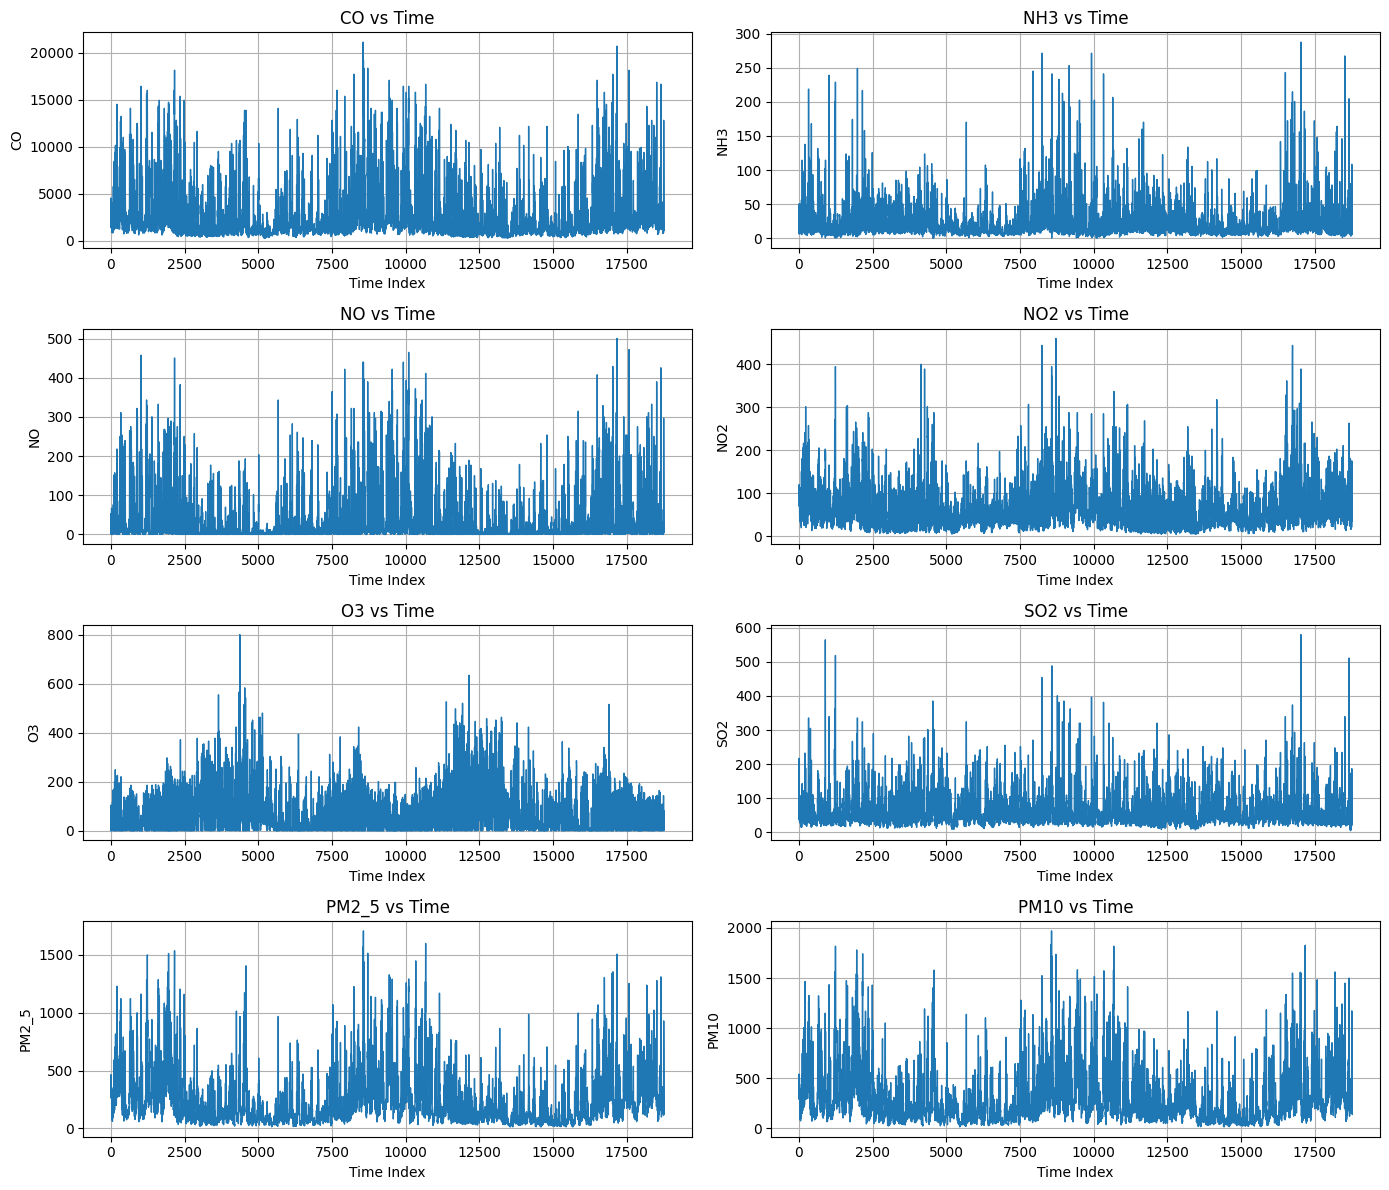

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
df = pd.read_csv(r"/content/delhi_aqi.csv")
df.dropna(inplace=True)
pollutants = ['co','nh3','no','no2','o3','so2','pm2_5','pm10']
# Reset index so index acts like time
df = df.reset_index().rename(columns={'index':'time'})
plt.figure(figsize=(14, 12))
for i, col in enumerate(pollutants, 1):
    plt.subplot(4, 2, i)#index vs the  pollutant level graphs
    plt.plot(df['time'], df[col], linewidth=1)
    plt.title(f"{col.upper()} vs Time")
    plt.xlabel("Time Index")
    plt.ylabel(f"{col.upper()}")
    plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
!pip install pmdarima


  Using cached pmdarima-2.0.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_28_x86_64.whl.metadata (7.8 kB)
Using cached pmdarima-2.0.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_28_x86_64.whl (2.3 MB)


Training samples: 1728, Testing samples: 432

✅ Performance for PM2_5:
RMSE = 400.37
R²   = -2.30


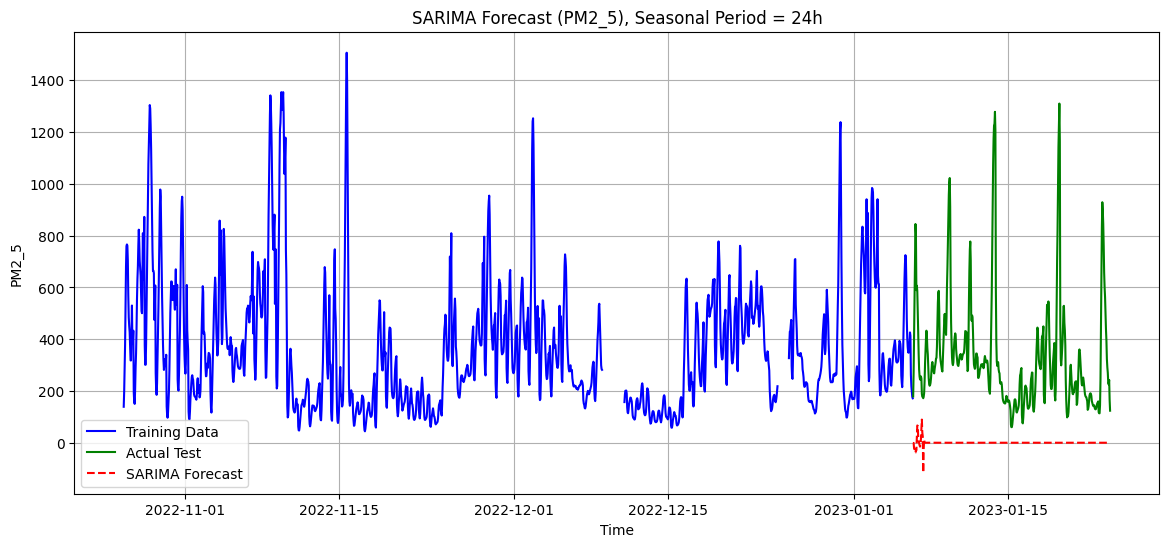

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings("ignore")
from statsmodels.tsa.statespace.sarimax import SARIMAX
df = pd.read_csv(r"/content/delhi_aqi.csv")
df.iloc[:, 0] = pd.to_datetime(df.iloc[:, 0], format="%d-%m-%Y %H:%M", dayfirst=True)
df.set_index(df.columns[0], inplace=True)
df.rename(columns={"pm_25": "pm2_5"}, inplace=True)
pollutant = "pm2_5"


# Train-test split (80/20) in temporal order
train_size = int(len(y) * 0.8)
train, test = y[:train_size], y[train_size:]

print(f"Training samples: {len(train)}, Testing samples: {len(test)}")

# Fast Seasonal ARIMA
# Uses (0,1,1) for trend and (0,1,1,24) for daily cycle
model = SARIMAX(train, order=(0,1,1), seasonal_order=(0,1,1,24), simple_differencing=True)
res = model.fit(disp=False)

# Forecast for test period
forecast = res.forecast(steps=len(test))
forecast = pd.Series(forecast, index=test.index).ffill().bfill()

# Evaluate the final results of the model
rmse = np.sqrt(mean_squared_error(test, forecast))
r2 = r2_score(test, forecast)
print(f" Performance for {pollutant.upper()}")
print(f"RMSE{rmse}")
print(f"R²{r2}")
plt.figure(figsize=(14,6))
plt.plot(train.index, train, label="Training Data", color="blue")
plt.plot(test.index, test, label="Actual Test", color="green")
plt.plot(forecast.index, forecast, label="SARIMA Forecast", linestyle="--", color="red")
plt.title(f"SARIMA Forecast ({pollutant.upper()}), Seasonal Period = 24h")
plt.xlabel("Time")
plt.ylabel(pollutant.upper())
plt.legend()
plt.grid(True)
plt.show()


Training samples: 1728, Testing samples: 432

✅ Performance for PM2_5:
RMSE = 401.44
R²   = -2.32


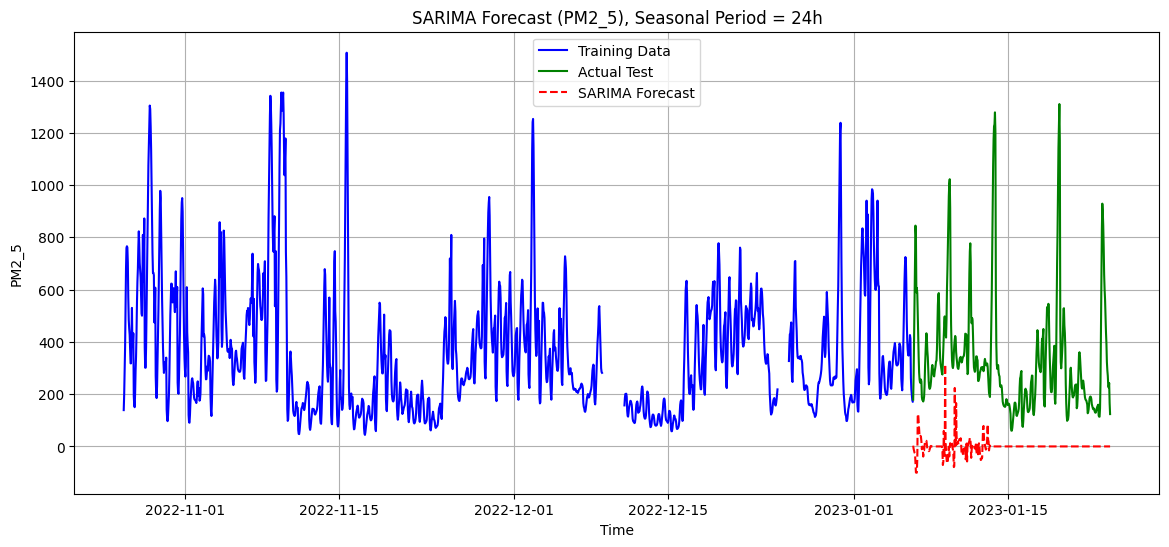

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings("ignore")
from statsmodels.tsa.statespace.sarimax import SARIMAX
df = pd.read_csv(r"/content/delhi_aqi.csv")
df.iloc[:, 0] = pd.to_datetime(df.iloc[:, 0], format="%d-%m-%Y %H:%M", dayfirst=True)
df.set_index(df.columns[0], inplace=True)
df.rename(columns={"pm_25": "pm2_5"}, inplace=True)
pollutant = "pm2_5"
y = pd.to_numeric(df[pollutant], errors="coerce").interpolate().ffill().bfill()
y = y.asfreq("H")
y = y.tail(24*90)
# Train-test split (80/20, preserve time order)
train_size = int(len(y) * 0.8)
train, test = y[:train_size], y[train_size:]
print(f"Training samples: {len(train)}, Testing samples: {len(test)}")

#Fast Seasonal ARIMA
# Uses (0,1,1) for trend and (0,1,1,24) for daily cycle
# This is fast and robust for pollutant data
model = SARIMAX(train, order=(0,1,1), seasonal_order=(0,1,1,168), simple_differencing=True)
res = model.fit(disp=False)
forecast = res.forecast(steps=len(test))
forecast = pd.Series(forecast, index=test.index).ffill().bfill()

# Evaluation of the model
rmse = np.sqrt(mean_squared_error(test, forecast))
r2 = r2_score(test, forecast)

print(f"Performance = {pollutant.upper()}:")
print(f"RMSE {rmse:.2f}")
print(f"R²{r2:.2f}")
plt.figure(figsize=(14,6))
plt.plot(train.index, train, label="Training Data", color="blue")
plt.plot(test.index, test, label="Actual Test", color="green")
plt.plot(forecast.index, forecast, label="SARIMA Forecast", linestyle="--", color="red")
plt.title(f"SARIMA Forecast ({pollutant.upper()}), Seasonal Period = 24h")
plt.xlabel("Time")
plt.ylabel(pollutant.upper())
plt.legend()
plt.grid(True)
plt.show()


FOR monthly seasonality we ran it on local machine due to low RAM :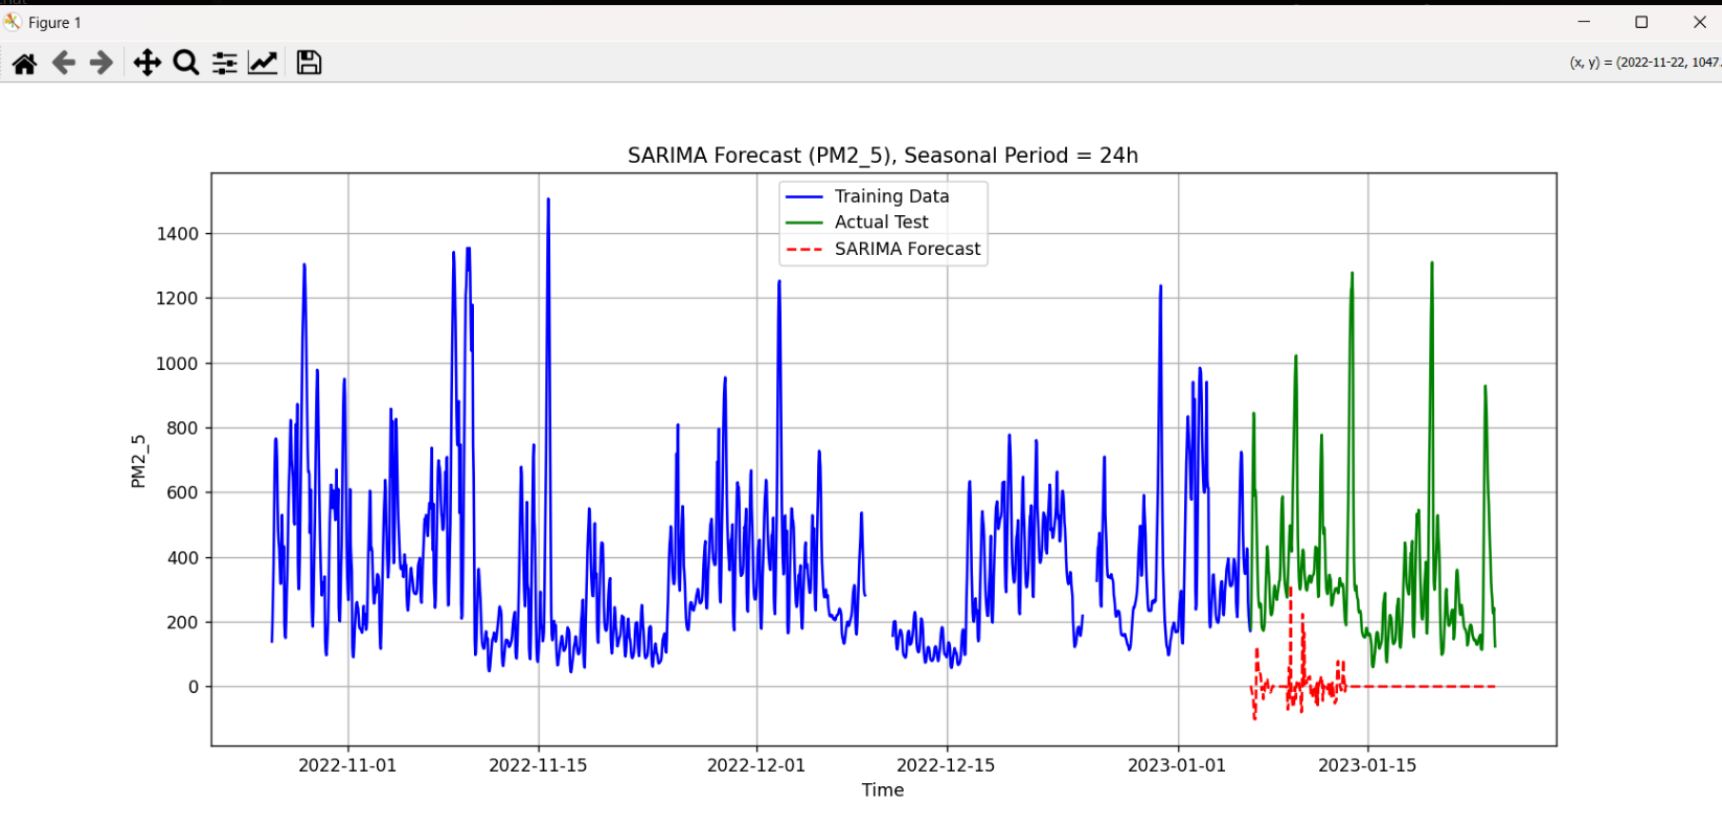

THEREFORE WE CONCLUDE THAT USING individual pollutants forecast into the future via any method and then using thode future values as input samples for the model is not feasible therefore we shift to the advance modelling techniques like bidirectional LSTMS.